In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

C:\Users\Anurag\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
Past_ticks = 1000
CM = []
val_cnt = []


for Fut_ticks in range(5,11):
    
    df = pd.read_csv('orderbook.csv')
    df = df[536:]
    df = df.drop_duplicates('timestamp', keep='first')
    df = df.reset_index(drop = True)

    df['b_a_spread'] = df['BINANCE_BTC-USDT_ask_1'] - df['BINANCE_BTC-USDT_bid_1']
    df = df.loc[df['b_a_spread']>0]
        
    df['b12'] = df['BINANCE_BTC-USDT_bid_1'] - df['BINANCE_BTC-USDT_bid_2']
    df['b13'] = df['BINANCE_BTC-USDT_bid_1'] - df['BINANCE_BTC-USDT_bid_3']
    df['b14'] = df['BINANCE_BTC-USDT_bid_1'] - df['BINANCE_BTC-USDT_bid_4']

    df['aten1'] = df['BINANCE_BTC-USDT_ask_1'] - df['BINANCE_BTC-USDT_ask_2']
    df['aten2'] = df['BINANCE_BTC-USDT_ask_1'] - df['BINANCE_BTC-USDT_ask_3']
    df['aten3'] = df['BINANCE_BTC-USDT_ask_1'] - df['BINANCE_BTC-USDT_ask_4']

    Total_P_ask = df['BINANCE_BTC-USDT_ask_1']+df['BINANCE_BTC-USDT_ask_10']+df['BINANCE_BTC-USDT_ask_2']+df['BINANCE_BTC-USDT_ask_3']+df['BINANCE_BTC-USDT_ask_4']+df['BINANCE_BTC-USDT_ask_5']+df['BINANCE_BTC-USDT_ask_6']+df['BINANCE_BTC-USDT_ask_7']+df['BINANCE_BTC-USDT_ask_8']+df['BINANCE_BTC-USDT_ask_9']
    Total_P_bid = df['BINANCE_BTC-USDT_bid_1']+df['BINANCE_BTC-USDT_bid_10']+df['BINANCE_BTC-USDT_bid_2']+df['BINANCE_BTC-USDT_bid_3']+df['BINANCE_BTC-USDT_bid_4']+df['BINANCE_BTC-USDT_bid_5']+df['BINANCE_BTC-USDT_bid_6']+df['BINANCE_BTC-USDT_bid_7']+df['BINANCE_BTC-USDT_bid_8']+df['BINANCE_BTC-USDT_bid_9']

    Total_V_ask = df['BINANCE_BTC-USDT_askq_1']+df['BINANCE_BTC-USDT_askq_10']+df['BINANCE_BTC-USDT_askq_2']+df['BINANCE_BTC-USDT_askq_3']+df['BINANCE_BTC-USDT_askq_4']+df['BINANCE_BTC-USDT_askq_5']+df['BINANCE_BTC-USDT_askq_6']+df['BINANCE_BTC-USDT_askq_7']+df['BINANCE_BTC-USDT_askq_8']+df['BINANCE_BTC-USDT_askq_9']
    Total_V_bid = df['BINANCE_BTC-USDT_bidq_1']+df['BINANCE_BTC-USDT_bidq_10']+df['BINANCE_BTC-USDT_bidq_2']+df['BINANCE_BTC-USDT_bidq_3']+df['BINANCE_BTC-USDT_bidq_4']+df['BINANCE_BTC-USDT_bidq_5']+df['BINANCE_BTC-USDT_bidq_6']+df['BINANCE_BTC-USDT_bidq_7']+df['BINANCE_BTC-USDT_bidq_8']+df['BINANCE_BTC-USDT_bidq_9']

    df['mid_p_Y'] = (df['BINANCE_BTC-USDT_ask_1'] + df['BINANCE_BTC-USDT_bid_1']) / 2

    df['acc_diff_P'] = Total_P_ask - Total_P_bid
    df['acc_diff_v'] = Total_V_ask - Total_V_bid
    df['mean_P_ask'] = Total_P_ask / 10
    df['mean_P_bid'] = Total_P_bid / 10
    df['mean_V_ask'] = Total_V_ask / 10
    df['mean_V_bid'] = Total_V_bid / 10
        
    # Return calculated w.r.t. future values
    df['mid_P_future'] = df['mid_p_Y'].shift(-Fut_ticks)
    df = df[:-Fut_ticks]
    df['Ret'] = (df['mid_P_future'] / df['mid_p_Y']) - 1
    df['Ret'] = df['Ret'] * 10000
    
    # Slope calculated w.r.t. past values
    df['mid_P_past'] = df['mid_p_Y'].shift(Past_ticks)
    df['BINANCE_BTC-USDT_bid_1_past'] = df['BINANCE_BTC-USDT_bid_1'].shift(Past_ticks)
    df['BINANCE_BTC-USDT_ask_1_past'] = df['BINANCE_BTC-USDT_ask_1'].shift(Past_ticks)
    df['timestamp_past'] = df['timestamp'].shift(Past_ticks)
    df = df[Past_ticks:]
    df = df.reset_index(drop=True)
    df['time_gap'] = df['timestamp'] - df['timestamp_past'] 
    df['BINANCE_BTC-USDT_bid_1_slope'] = (df['BINANCE_BTC-USDT_bid_1'] - df['BINANCE_BTC-USDT_bid_1_past']) / df['time_gap']
    df['BINANCE_BTC-USDT_ask_1_slope'] = (df['BINANCE_BTC-USDT_ask_1'] - df['BINANCE_BTC-USDT_ask_1_past']) / df['time_gap']
    df['mid_P_slope'] = (df['mid_p_Y'] - df['mid_P_past']) / df['time_gap']
    
    col = list(df)
    
    X_col = []
    ind = [0, 2, 44, 45, 46, 50, 68, 70, 73, 76, 78, 79, 80, 81, 82, 83]
    for i in ind:
        X_col.append(col[i])
    
    df = df[:-40]
    
    Feat = df[X_col]
    Lab = df[['Ret']]
    
    percentile = np.percentile(Lab[:-35500].values, 90)
    #percentile = 5.01
    print("Percentile = ",percentile)
    
    # 2 = Positive
    # 1 = Negative
    # 0 = Neutral
    
    Lab_cod = pd.DataFrame(columns = Lab.columns, index = Lab.index)
    Lab_cod['Ret'] = 0
    
    mask1 = Lab['Ret'] >= percentile 
    mask2 = Lab['Ret'] <= -percentile
    
    column_name = 'Ret'
    Lab_cod.loc[mask1, column_name] = 2
    Lab_cod.loc[mask2, column_name] = 1
    
    val_cnt.append((Lab_cod['Ret'].value_counts()))
    
    X = Feat.values
    y = Lab_cod.values
    y = y.reshape(-1,1)
    
    X_train = X[:-35500, :]
    y_train = y[:-35500, :]
    X_test = X[-35500:, :]
    y_test = y[-35500:, :]
    
    sc_X = StandardScaler()
    X_train_scaled = sc_X.fit_transform(X_train)
    X_test_scaled = sc_X.transform(X_test)
    
    dummy_y = np_utils.to_categorical(y_train)
    
    model = Sequential()
    model.add(Dense(output_dim = 8, input_dim=16, activation='relu'))
    model.add(Dense(output_dim = 4, activation='relu'))
    model.add(Dense(output_dim = 3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    history = model.fit(X_train_scaled, dummy_y, batch_size=16, validation_split = 0.2, epochs=5)
    print(history.history.keys())
    
    predictions = model.predict(X_test_scaled)
    result = np.argmax(predictions,axis=1)
    
    ResDF = df[['BINANCE_BTC-USDT_bid_1', 'BINANCE_BTC-USDT_ask_1']][-35500:]
    ResDF = ResDF.reset_index(drop=True)
    ResDF['Predicted'] = result
    ResDF['Real'] = y_test
    
    cm = confusion_matrix(y_test, ResDF['Predicted'])
    CM.append(cm)

Percentile =  0.7964954201522545


C:\Users\Anurag\Anaconda3\lib\site-packages\ipykernel_launcher.py:105: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=16, activation="relu", units=8)`
C:\Users\Anurag\Anaconda3\lib\site-packages\ipykernel_launcher.py:106: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=4)`
C:\Users\Anurag\Anaconda3\lib\site-packages\ipykernel_launcher.py:107: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=3)`


Train on 114170 samples, validate on 28543 samples
Epoch 1/5
114170/114170 [==============================] - 16s 144us/step - loss: 0.6558 - acc: 0.7930 - val_loss: 0.6940 - val_acc: 0.7693
Epoch 2/5
114170/114170 [==============================] - 16s 141us/step - loss: 0.6058 - acc: 0.8077 - val_loss: 0.6855 - val_acc: 0.7693
Epoch 3/5
114170/114170 [==============================] - 15s 135us/step - loss: 0.6015 - acc: 0.8078 - val_loss: 0.6793 - val_acc: 0.7694
Epoch 4/5
114170/114170 [==============================] - 14s 123us/step - loss: 0.5883 - acc: 0.8078 - val_loss: 0.6543 - val_acc: 0.7694
Epoch 5/5
114170/114170 [==============================] - 16s 144us/step - loss: 0.5263 - acc: 0.8102 - val_loss: 0.5429 - val_acc: 0.7749
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
Percentile =  1.1745820445563382
Train on 114169 samples, validate on 28543 samples
Epoch 1/5
114169/114169 [==============================] - 15s 127us/step - loss: 0.6507 - acc: 0.7947 - val_loss: 

In [4]:
c = 5
for i in val_cnt:
    print("\tt +",c)
    c=c+1
    print(i, "\n\n")

	t + 5
0    141720
2     18297
1     18196
Name: Ret, dtype: int64 


	t + 6
0    143304
2     17540
1     17368
Name: Ret, dtype: int64 


	t + 7
0    142278
2     17999
1     17934
Name: Ret, dtype: int64 


	t + 8
0    143126
2     17658
1     17426
Name: Ret, dtype: int64 


	t + 9
0    142932
2     17752
1     17525
Name: Ret, dtype: int64 


	t + 10
0    142363
2     18068
1     17777
Name: Ret, dtype: int64 




In [15]:
qwe = sum(CM[0][1])

In [31]:
c=5
for i in CM:
    print("\tt +",c)
    c=c+1
    print(i, "\n\n")
    

	t + 5
[[27506     0     0]
 [ 3747   230     0]
 [ 4017     0     0]] 


	t + 6
[[29178     0     4]
 [ 2209   835     7]
 [ 2779     0   488]] 


	t + 7
[[28029     0   255]
 [ 2794   691     6]
 [ 2371     0  1354]] 


	t + 8
[[28920    17   116]
 [  888  2183     1]
 [  855     0  2520]] 


	t + 9
[[28707     0   100]
 [ 1381  1840     0]
 [  458     0  3014]] 


	t + 10
[[27856   333     4]
 [  313  3204     2]
 [ 1835     0  1953]] 




In [24]:
Neg = []
Pos = []

for c in CM:
    Neg.append(c[1][1]/sum(c[1]))
    Pos.append(c[2][2]/sum(c[2]))

In [29]:
Neg

[0.05783253708825748,
 0.27368076040642414,
 0.1979375537095388,
 0.7106119791666666,
 0.5712511642347097,
 0.9104859335038363]

In [30]:
Pos

[0.0,
 0.14937251300887663,
 0.36348993288590603,
 0.7466666666666667,
 0.8680875576036866,
 0.5155755015839493]

In [25]:
x = [5, 6, 7, 8, 9, 10]

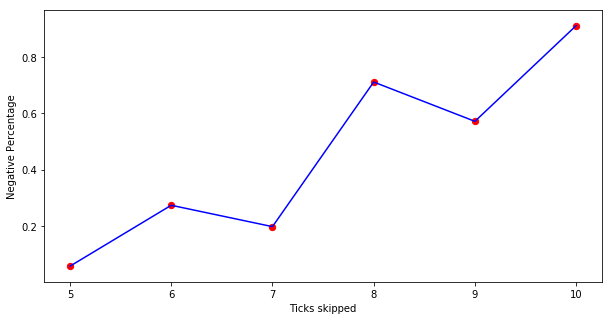

In [26]:
plt.figure(figsize = (10,5))
plt.ylabel('Negative Percentage')
plt.xlabel('Ticks skipped')
plt.scatter(x, Neg, color='r', s=40)
plt.plot(x, Neg, color='b')

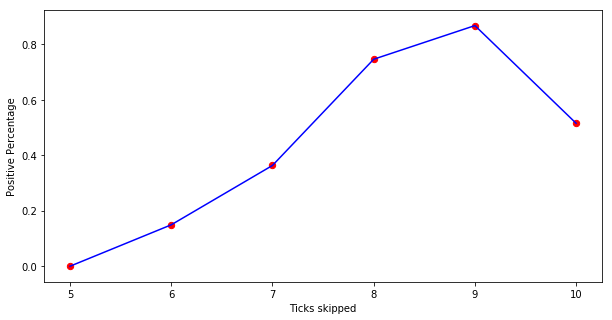

In [27]:
plt.figure(figsize = (10,5))
plt.ylabel('Positive Percentage')
plt.xlabel('Ticks skipped')
plt.scatter(x, Pos, color='r', s=40)
plt.plot(x, Pos, color='b')

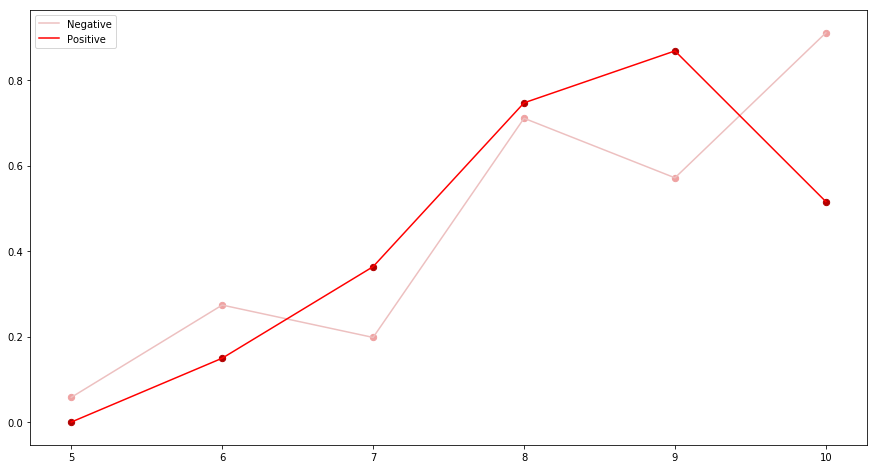

In [28]:
plt.figure(figsize = (15,8))
#plt.ylabel('Negative Percentage')

plt.scatter(x, Neg, color='#efa2a2', s=40)
plt.plot(x, Neg, color='#edc0c0')

plt.scatter(x, Pos, color='#b20101', s=40)
plt.plot(x, Pos, color='red')



plt.legend(['Negative', 'Positive'])
plt.show()

In [11]:
Infer = []
for i in range(len(ResDF)):
    if ResDF['Predicted'][i] == 2 and ResDF['Real'][i] == 2:
        Infer.append("True Positive")
    elif ResDF['Predicted'][i] == 1 and ResDF['Real'][i] == 1:
        Infer.append("True Negative")
    else:
        Infer.append("Other")

ResDF["Infer"] = Infer
Tru_pos = ResDF[ResDF['Infer'] == 'True Positive']
Tru_neg = ResDF[ResDF['Infer'] == 'True Negative']

In [12]:
print(len(Tru_pos), len(Tru_neg))

1953 3204


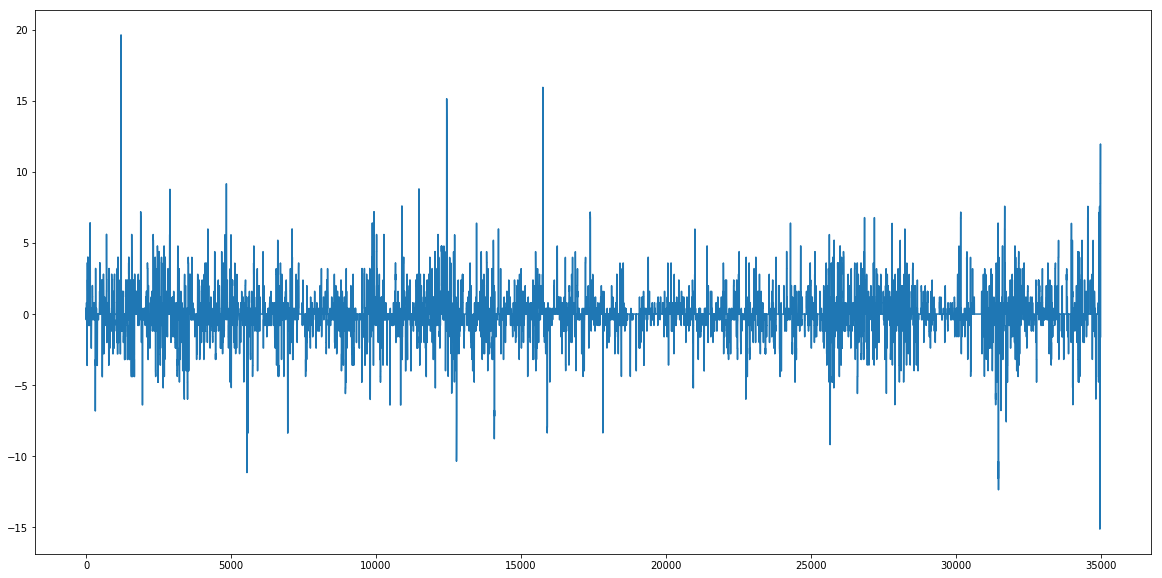

In [13]:
plt.figure(figsize=(20,10))
plt.plot(df['Ret'][-35000:].values)
plt.show()

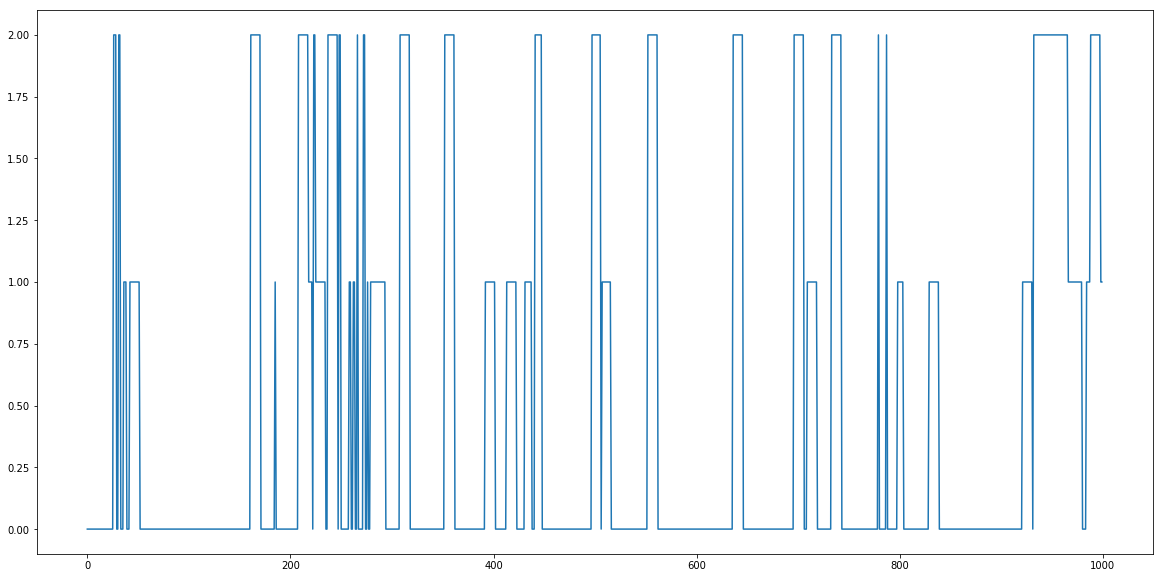

In [14]:
plt.figure(figsize=(20,10))
plt.plot(Lab_cod[-1000:].values)
plt.show()